# VQVAE

Typically, the latent variable in a Variational Autoencoder (VAE) is modeled as a continuous distribution. However, as pointed out by Oord in the paper "Neural Discrete Representation Learning", there are scenarios where a discrete representation might be more suitable. For example, human natural language is inherently a discrete modality. Motivated by this, Oord proposed the vector quantized variational autoencoder (VQVAE), which learns a discrete latent space representation. The overall architecture of VQVAE is similar to a typical VAE. It has an encoder and a decoder. The only difference is that VQVAE includes quantizer after the encoder. <br>

The quantizer in VQ-VAE stores a codebook that contains a list of embedding vectors. It processes the encoded information by replacing each encoded vector with its nearest neighbor from the codebook. This quantization step effectively maps the continuous latent space into a discrete space. The decoder then learns to reconstruct the input data from these discrete embeddings.<br>

After training the VQVAE, we can then use it for sampling. We can train a prior on the codebook and then use the decoder to decode the generated image.

## VQVAE Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

mnist_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

mnist_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=64, shuffle=False)

cifar_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

cifar_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

cifar_train_loader = DataLoader(cifar_train_dataset, batch_size=64, shuffle=True)
cifar_test_loader = DataLoader(cifar_test_dataset, batch_size=64, shuffle=False)

## Implementation of encoder and decoder

In [5]:
class Encoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        ## Input: [B, 3, 32, 32] ==> [B, out_dim, 8, 8]
        super(Encoder, self).__init__()
        self.net = nn.Sequential(nn.Conv2d(in_dim, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
                                 nn.BatchNorm2d(hidden_dim),
                                 nn.ReLU(),
                                 nn.Conv2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
                                 nn.BatchNorm2d(hidden_dim),
                                 nn.ReLU(),
                                 ResidualBlock(hidden_dim),
                                 nn.BatchNorm2d(hidden_dim),
                                 ResidualBlock(hidden_dim),
                                 nn.BatchNorm2d(hidden_dim),
                                 nn.Conv2d(hidden_dim, out_dim, kernel_size=1, bias=False))

    def forward(self, x):
        out = self.net(x)
        return out

class Decoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        ## Input: [B, 3, 8, 8] ==> [B, 3, 32, 32]
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_dim, hidden_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            ResidualBlock(hidden_dim),
            nn.BatchNorm2d(hidden_dim),
            ResidualBlock(hidden_dim),
            nn.BatchNorm2d(hidden_dim),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, out_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh())

    def forward(self, x):
        out = self.net(x)
        return out

In [7]:
class VectorQuantizer(nn.Module):
    def __init__(self, embed_dim, n_embedding):
        super(VectorQuantizer, self).__init__()
        self.dictionary = nn.Parameter(torch.rand(n_embedding, embed_dim))

    def forward(self, x):
        ## [B, E, 8, 8] ==> [B, E, 8, 8]
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).contiguous() #[B, H, W, E]
        x = x.view(x.size(0), -1, self.dictionary.shape[1])  #[B, H*W, E], [B, N, E]
        dist = torch.cdist(x, self.dictionary.repeat((x.size(0), 1, 1)))  #[B, H*W, N]
        idx = torch.argmin(dist, dim=-1).view(-1) #[B*H*W]
        out = torch.index_select(self.dictionary, dim=0, index=idx)  #[B*H*W, E]
        out = out.view(x.size(0), -1, out.size(-1))    #[B, H*W, E]
        commitment_loss = torch.mean((out.detach() - x) ** 2)
        codebook_loss = torch.mean((out - x.detach()) ** 2)
        out = x + (out - x).detach()
        out = out.view(B, H, W, C).permute(0, 3, 1, 2).contiguous()
        idx = idx.view(B, H, W)
        return out, commitment_loss, codebook_loss, idx

## Implement VQVAE

In [39]:
class VQVAE(nn.Module):
    def __init__(self, in_dim, hidden_dim, embed_dim, n_embedding):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(in_dim, hidden_dim, embed_dim)
        self.quantizer = VectorQuantizer(embed_dim, n_embedding)
        self.decoder  = Decoder(embed_dim, hidden_dim, in_dim)
        self.in_dim = in_dim
        self.embed_dim = embed_dim

    def forward(self, x):
        out = self.encoder(x)
        out, commitment_loss, codebook_loss, _ = self.quantizer(out)
        out = self.decoder(out)
        return out, commitment_loss, codebook_loss

## Training VQVAE

In [ ]:
model = VQVAE(in_dim=1, hidden_dim=64, embed_dim=128, n_embedding=3).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, train_loader, optimizer, n_epochs=10, device=DEVICE)

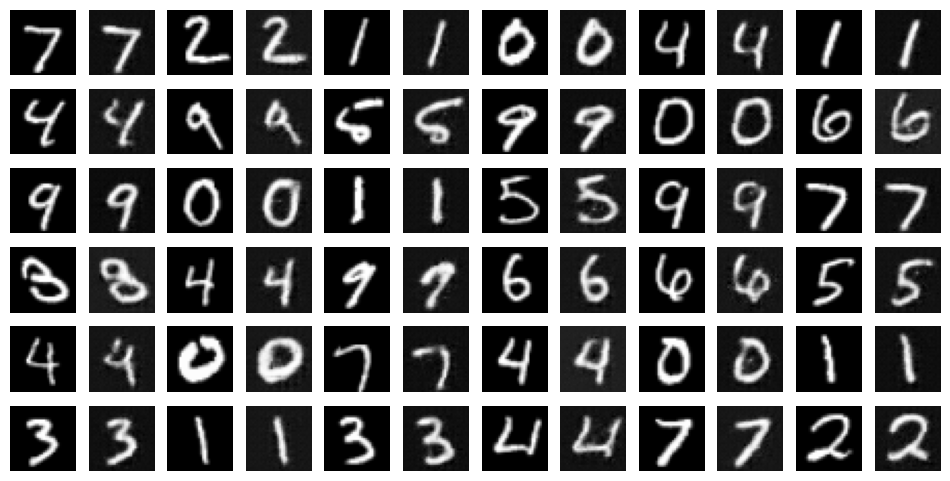

In [22]:
plot_reconstruction(mnist_test_loader)

## Train on CIFAR10

In [ ]:
model = VQVAE(in_dim=3, hidden_dim=128, embed_dim=256, n_embedding=128).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train(model, train_loader, optimizer, n_epochs=10, device=DEVICE)

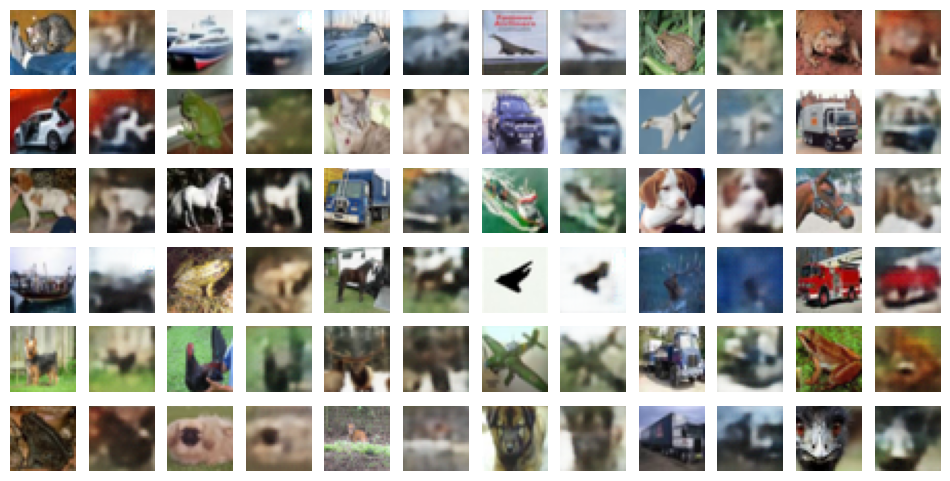

In [72]:
plot_reconstruction(cifar_test_loader)

## PixelCNN implementation

## Train the PixelCNN for generation

In [ ]:
vqvae = VQVAE(in_dim=1, hidden_dim=64, embed_dim=128, n_embedding=3).to(DEVICE)
vqvae.load_state_dict(torch.load('./vqvae_mnist.pth'))
prior = PixelCNN(in_channels=1, hidden_channels=64, n_classes=3, n_layers=3, height=8, width=8).to(DEVICE)
optimizer = optim.Adam(prior.parameters(), lr=1e-3)
train(prior, vqvae, train_loader, optimizer, n_epochs=20, device=DEVICE)

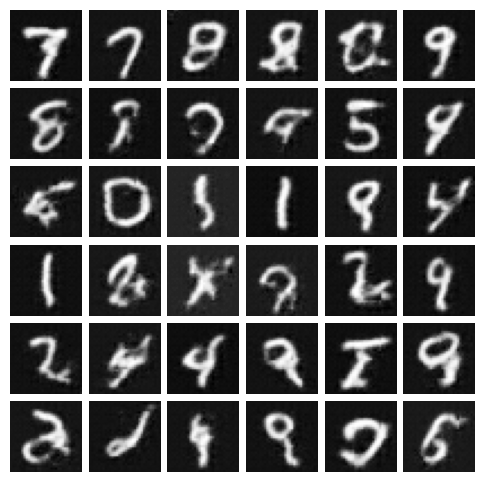

In [38]:
plot_samples(n_samples, vqvae, prior)

## Train prior on Cifar10

In [76]:
vqvae = VQVAE(in_dim=3, hidden_dim=128, embed_dim=256, n_embedding=128).to(DEVICE)
vqvae.load_state_dict(torch.load('./vqvae_cifar10.pth'))
prior = PixelCNN(in_channels=3, hidden_channels=64, n_classes=128, n_layers=3, height=8, width=8).to(DEVICE)
optimizer = optim.Adam(prior.parameters(), lr=1e-3)
train(prior, vqvae, train_loader, optimizer, n_epochs=20, device=DEVICE)

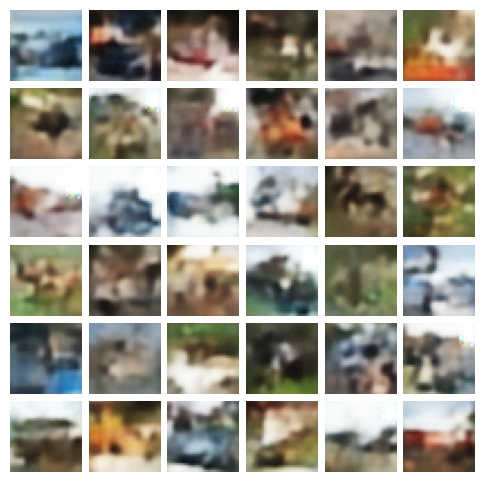

In [83]:
plot_samples(n_samples, vqvae, prior)